# NFL Combine Draft Classification  
## A Logistic Regression Analysis

### Eric Au

<img src="https://library.sportingnews.com/styles/twitter_card_120x120/s3/2022-03/Antoine-Winfield-030222-GETTY-FTR.jpg?itok=nG3hUgf_" width="500" length = "200"/>

Source: <a href="https://www.sportingnews.com/us/nfl/news/nfl-combine-drills-explained-40-yard-dash/lds11epxn7znufqyjkaphguq">Getty Images</a>

### Business and Data Understanding

Every year, the National Football League (NFL) holds a week long showcase where college football players, otherwise known as prospects, perform physical drills and tests in front of team coaches, scouts, and general managers. These drills are intended to measure a player's physical ability such as speed, quickness, strength, and overall athleticism. 

But what can NFL teams learn from these workouts? What exactly do the non-football athletic testing measurements contribute to prospect evaluation? These are a questions that many fans ask to this day and NFL teams try to interpret to make the best decision possible when drafting their players. 

For this analysis, we will be using player combine data scraped from <a href = "https://www.pro-football-reference.com/">Pro-Football Reference</a> over the last 22 years (2000-2022). 

Each record represents an individual player who was eligible to be drafted with information related to their combine measurements. Additionally, each record indicates whether that player was `Drafted` with 1 for "Yes" and 0 for "No". This will be further clarified in the preliminary cleaning of the data set. 

**Create a model that determines whether a player was `Drafted` based on the available data and information provided in the NFL Combine.** 

We will attempt to find any significance between the combine and draft status as well as explore the following: 
- How significant are measurables in determining draft status? 
- What do the metrics distributions look like for the skill positions?

**Stakeholders:** The New York Giants front office (General Manager, President, Scouting Department). 


In [1]:
# import libraries 
import pandas as pd
import numpy as np
import math
import xgboost as xgb

import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

from sklearn.preprocessing import OneHotEncoder, StandardScaler, MaxAbsScaler
from sklearn.impute import SimpleImputer

from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_score, \
RandomizedSearchCV, StratifiedKFold, KFold
from sklearn.feature_selection import SelectFromModel

from sklearn.compose import ColumnTransformer

from sklearn.neighbors import KNeighborsClassifier

from sklearn.metrics import precision_score, recall_score, f1_score, accuracy_score, classification_report
from sklearn.metrics import log_loss
from sklearn.metrics import plot_confusion_matrix
from sklearn.metrics import confusion_matrix
from sklearn.metrics import plot_roc_curve
from sklearn.metrics import make_scorer

from sklearn.base import clone

# ignore warnings
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)
pd.options.mode.chained_assignment = None 

In [2]:
# load in data
df = pd.read_csv('Data/combine_2000_2022.csv', index_col = 0)
df.head()

,Player,Pos,School,College,Ht,Wt,40yd,Vertical,Bench,Broad Jump,3Cone,Shuttle,Drafted (tm/rnd/yr),Year
0,John Abraham,OLB,South Carolina,NaN,6-4,252.0,4.55,NaN,NaN,NaN,NaN,NaN,New York Jets / 1st / 13th pick / 2000,2000
1,Shaun Alexander,RB,Alabama,College Stats,6-0,218.0,4.58,NaN,NaN,NaN,NaN,NaN,Seattle Seahawks / 1st / 19th pick / 2000,2000
2,Darnell Alford,OT,Boston Col.,NaN,6-4,334.0,5.56,25.0,23.0,94.0,8.48,4.98,Kansas City Chiefs / 6th / 188th pick / 2000,2000
3,Kyle Allamon,TE,Texas Tech,NaN,6-2,253.0,4.97,29.0,NaN,104.0,7.29,4.49,NaN,2000
4,Rashard Anderson,CB,Jackson State,NaN,6-2,206.0,4.55,34.0,NaN,123.0,7.18,4.15,Carolina Panthers / 1st / 23rd pick / 2000,2000


In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 7680 entries, 0 to 7820
Data columns (total 14 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   Player               7680 non-null   object 
 1   Pos                  7680 non-null   object 
 2   School               7680 non-null   object 
 3   College              6240 non-null   object 
 4   Ht                   7651 non-null   object 
 5   Wt                   7656 non-null   float64
 6   40yd                 7206 non-null   float64
 7   Vertical             5932 non-null   float64
 8   Bench                5096 non-null   float64
 9   Broad Jump           5859 non-null   float64
 10  3Cone                4792 non-null   float64
 11  Shuttle              4895 non-null   float64
 12  Drafted (tm/rnd/yr)  4937 non-null   object 
 13  Year                 7680 non-null   int64  
dtypes: float64(7), int64(1), object(6)
memory usage: 900.0+ KB


## Initial Data Preparation
The following steps below are preliminary data cleaning just to get the dataframe in a working set condition for the `train_test_split`. Handling of missing values will be performed following the split. 

### Convert to float types in appropriate columns; 

In [4]:
# create a list of columns that need to be floats
col_floats = ['Wt', '40yd', 'Vertical', 'Bench', 'Broad Jump', '3Cone', 'Shuttle']

In [5]:
# convert to type float for col_floats columns
df[col_floats].astype(float)

,Wt,40yd,Vertical,Bench,Broad Jump,3Cone,Shuttle
0,252.0,4.55,NaN,NaN,NaN,NaN,NaN
1,218.0,4.58,NaN,NaN,NaN,NaN,NaN
2,334.0,5.56,25.0,23.0,94.0,8.48,4.98
3,253.0,4.97,29.0,NaN,104.0,7.29,4.49
4,206.0,4.55,34.0,NaN,123.0,7.18,4.15
...,...,...,...,...,...,...,...
7816,304.0,4.77,29.0,NaN,111.0,NaN,NaN
7817,255.0,NaN,NaN,NaN,NaN,NaN,NaN
7818,206.0,NaN,NaN,12.0,NaN,NaN,NaN
7819,316.0,5.13,28.5,27.0,110.0,7.75,4.71


### Remove missing data

In [6]:
# there are 29 missing heights in the dataframe
missing_heights = df[df['Ht'].isna()].index
len(missing_heights)

29

In [7]:
# remove these rows from the df
df = df.drop(missing_heights)

In [8]:
# check shape (7680 - 29) = 7651
df.shape

(7651, 14)

### Convert `Height` to appropriate float value

In [9]:
# create feet and inches columns to seperate the 'Ht'
df['feet'] = df['Ht'].str.split("-").str[0].astype(int)
df['inches'] = df['Ht'].str.split("-").str[1].astype(int)

# add new Height column that calculates height as a float
df['Height'] = df['feet'] + round((df['inches']/12),2)

In [10]:
# remove unneeded columns and extra columns created
df = df.drop(columns = ['Player', 'Ht', 'College','feet', 'inches', 'Year'])

In [11]:
# rename the columns
df = df[['Pos', 'School', 'Wt', '40yd', 'Vertical', 'Bench',
       'Broad Jump', '3Cone', 'Shuttle', 'Drafted (tm/rnd/yr)', 'Height']]

### Create binary `Drafted ` Column of 1 - Yes, 0 - No if player was drafted

In [12]:
# fill missing in drafted column with 0
df['Drafted (tm/rnd/yr)'] = df['Drafted (tm/rnd/yr)'].fillna(0)

In [13]:
# create new column Drafted that designates whether drafted (1) or not (0)
df['Drafted'] = np.where(df['Drafted (tm/rnd/yr)'] == 0, 0, 1)

# drop extra drafted column now
df.drop(columns = 'Drafted (tm/rnd/yr)', inplace = True)

In [14]:
df.head(5)

,Pos,School,Wt,40yd,Vertical,Bench,Broad Jump,3Cone,Shuttle,Height,Drafted
0,OLB,South Carolina,252.0,4.55,NaN,NaN,NaN,NaN,NaN,6.33,1
1,RB,Alabama,218.0,4.58,NaN,NaN,NaN,NaN,NaN,6.00,1
2,OT,Boston Col.,334.0,5.56,25.0,23.0,94.0,8.48,4.98,6.33,1
3,TE,Texas Tech,253.0,4.97,29.0,NaN,104.0,7.29,4.49,6.17,0
4,CB,Jackson State,206.0,4.55,34.0,NaN,123.0,7.18,4.15,6.17,1


In [15]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 7651 entries, 0 to 7820
Data columns (total 11 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   Pos         7651 non-null   object 
 1   School      7651 non-null   object 
 2   Wt          7651 non-null   float64
 3   40yd        7191 non-null   float64
 4   Vertical    5919 non-null   float64
 5   Bench       5082 non-null   float64
 6   Broad Jump  5850 non-null   float64
 7   3Cone       4784 non-null   float64
 8   Shuttle     4888 non-null   float64
 9   Height      7651 non-null   float64
 10  Drafted     7651 non-null   int64  
dtypes: float64(8), int64(1), object(2)
memory usage: 717.3+ KB


In [16]:
df.head()

,Pos,School,Wt,40yd,Vertical,Bench,Broad Jump,3Cone,Shuttle,Height,Drafted
0,OLB,South Carolina,252.0,4.55,NaN,NaN,NaN,NaN,NaN,6.33,1
1,RB,Alabama,218.0,4.58,NaN,NaN,NaN,NaN,NaN,6.00,1
2,OT,Boston Col.,334.0,5.56,25.0,23.0,94.0,8.48,4.98,6.33,1
3,TE,Texas Tech,253.0,4.97,29.0,NaN,104.0,7.29,4.49,6.17,0
4,CB,Jackson State,206.0,4.55,34.0,NaN,123.0,7.18,4.15,6.17,1


In [17]:
df.describe()

,Wt,40yd,Vertical,Bench,Broad Jump,3Cone,Shuttle,Height,Drafted
count,7651.000000,7191.000000,5919.000000,5082.000000,5850.000000,4784.000000,4888.000000,7651.000000,7651.000000
mean,242.735852,4.776540,32.892854,20.744392,114.590769,7.284933,4.399677,6.149007,0.643315
std,45.236972,0.304748,4.217085,6.378024,9.351811,0.417687,0.267133,0.220414,0.479052
min,144.000000,4.220000,17.500000,2.000000,74.000000,6.280000,3.730000,5.330000,0.000000
25%,205.000000,4.540000,30.000000,16.000000,109.000000,6.980000,4.200000,6.000000,0.000000
50%,232.000000,4.690000,33.000000,21.000000,116.000000,7.190000,4.360000,6.170000,1.000000
75%,280.000000,4.980000,36.000000,25.000000,121.000000,7.530000,4.560000,6.330000,1.000000
max,384.000000,6.050000,46.500000,49.000000,147.000000,9.120000,5.560000,6.830000,1.000000


In [18]:
# save as cleaned csv
df.to_csv('Data/cleaned_combine_2000_2022.csv')

## Exploratory Data Analysis

### Position Breakdown

- possibly come back here to see how final model performs based on splitting up by offensive and defensive positions

In [19]:
# check positions available
df['Pos'].value_counts()

WR      1058
CB       761
RB       671
S        559
OT       524
DE       519
DT       497
OLB      430
TE       425
QB       416
OG       403
ILB      276
C        184
LB       154
P        142
OL       139
FB       120
DL       116
K        103
EDGE      65
DB        59
LS        30
Name: Pos, dtype: int64

In [20]:
sorted_positions = df['Pos'].value_counts()
sorted_positions

WR      1058
CB       761
RB       671
S        559
OT       524
DE       519
DT       497
OLB      430
TE       425
QB       416
OG       403
ILB      276
C        184
LB       154
P        142
OL       139
FB       120
DL       116
K        103
EDGE      65
DB        59
LS        30
Name: Pos, dtype: int64

In [21]:
# create positions_df that orders positions by most frequent to least
positions = ['WR', 'CB', 'RB', 'S', 'OT', 'DE', 'DT', 'OLB', 'TE', 'QB', 'OG', 'ILB',
       'C', 'LB', 'P', 'OL', 'FB', 'DL', 'K', 'EDGE', 'DB', 'LS']

values = [1058,  761,  671,  559,  524,  519,  497,  430,  425,  416,  403,
        276,  184,  154,  142,  139,  120,  116,  103,   65,   59,   30]

data = {'Position': positions,
        'Count': values}

positions_df = pd.DataFrame(data,
                       columns=['Count'], 
                       index = positions)

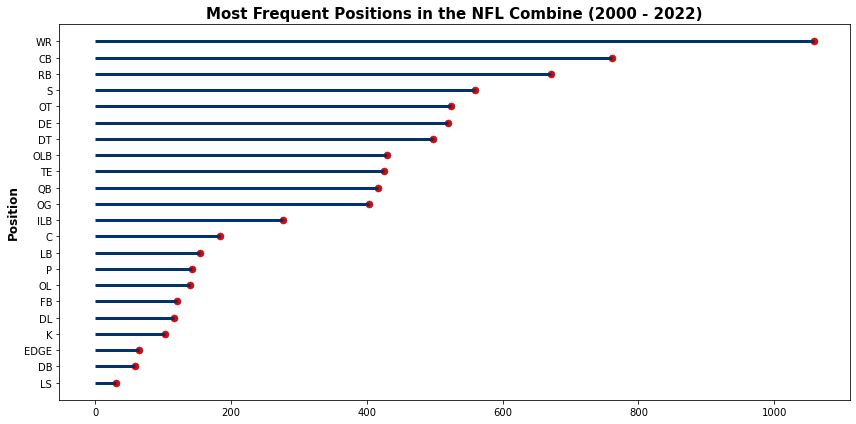

In [22]:
# plot a lollipop plot of most frequent positions in the combine
fig, ax = plt.subplots(figsize=(12, 6))
plt.style.use('bmh')

# create dataframe of positions & number of drafted
ordered_df = positions_df.sort_values(by = 'Count')

# plots the lines
plt.hlines(y = ordered_df.index,  # positions
           xmin = 0,
           xmax = ordered_df['Count'],  # Count values
           color = '#013369', linewidth = 3)

plt.scatter(ordered_df['Count'], # Count values
            ordered_df.index,  # positions
            color='#d50a0a', 
            alpha=1, s = 50)

plt.title('Most Frequent Positions in the NFL Combine (2000 - 2022)', weight = "bold", fontsize = 15)
plt.ylabel('Position', weight = "bold", fontsize = 12)

plt.tight_layout()
plt.show()

In [23]:
# list of offensive positions
offense_list = ['WR', 'RB', 'OT', 'TE', 'QB', 'OG', 'C', 'OL', 'FB']

# list of defensive positions
defense_list = ['CB', 'S', 'DE', 'DT', 'OLB', 'ILB', 'LB', 'DL', 'EDGE', 'DB']

# list of special team positions
special_teams_list = ['LS', 'K', 'P']

In [24]:
# split into offensive positions
offense = df.loc[df['Pos'].isin(offense_list)]

# split into defensive positions
defense = df.loc[df['Pos'].isin(defense_list)]

# split into special teams positions
special_teams = df.loc[df['Pos'].isin(special_teams_list)]

In [25]:
# percent and count breakdowns
# Offense
total_offense = len(offense)
total_offense_drafted = offense['Drafted'].value_counts()[1]
total_offense_undrafted = offense['Drafted'].value_counts()[0]
percent_off_drafted = round(offense['Drafted'].value_counts(normalize = True)[1], 2)
percent_off_undrafted = round(offense['Drafted'].value_counts(normalize = True)[0], 2)

print("Offense")
print(f"Total Players:      {total_offense}")
print(f"Total Drafted:      {total_offense_drafted}")
print(f"Total Undrafted:    {total_offense_undrafted}")
print(f"Percent Drafted:    {percent_off_drafted}")
print(f"Percent Undrafted:  {percent_off_undrafted}")
print("-"*25)

# Defense
total_defense = len(defense)
total_defense_drafted = defense['Drafted'].value_counts()[1]
total_defense_undrafted = defense['Drafted'].value_counts()[0]
percent_def_drafted = round(defense['Drafted'].value_counts(normalize = True)[1], 2)
percent_def_undrafted = round(defense['Drafted'].value_counts(normalize = True)[0], 2)

print("Defense")
print(f"Total Players:      {total_defense}")
print(f"Total Drafted:      {total_defense_drafted}")
print(f"Total Undrafted:    {total_defense_undrafted}")
print(f"Percent Drafted:    {percent_def_drafted}")
print(f"Percent Undrafted:  {percent_def_undrafted}")
print("-"*25)

# Special teams
total_st = len(special_teams)
total_st_drafted = special_teams['Drafted'].value_counts()[1]
total_st_undrafted = special_teams['Drafted'].value_counts()[0]
percent_st_drafted = round(special_teams['Drafted'].value_counts(normalize = True)[1], 2)
percent_st_undrafted = round(special_teams['Drafted'].value_counts(normalize = True)[0], 2)

print("Special Teams")
print(f"Total Players:      {total_st}")
print(f"Total Drafted:      {total_st_drafted}")
print(f"Total Undrafted:    {total_st_undrafted}")
print(f"Percent Drafted:    {percent_st_drafted}")
print(f"Percent Undrafted:  {percent_st_undrafted}")

Offense
Total Players:      3940
Total Drafted:      2447
Total Undrafted:    1493
Percent Drafted:    0.62
Percent Undrafted:  0.38
-------------------------
Defense
Total Players:      3436
Total Drafted:      2397
Total Undrafted:    1039
Percent Drafted:    0.7
Percent Undrafted:  0.3
-------------------------
Special Teams
Total Players:      275
Total Drafted:      78
Total Undrafted:    197
Percent Drafted:    0.28
Percent Undrafted:  0.72


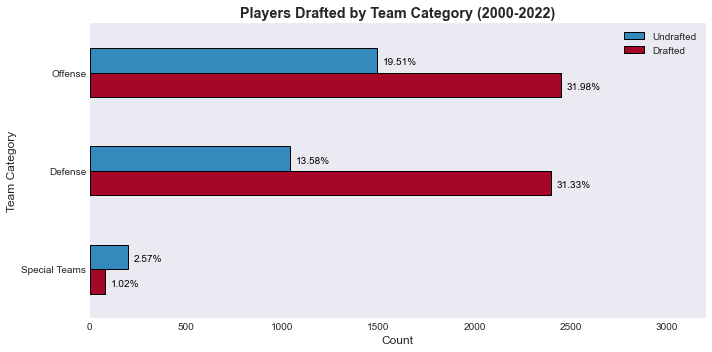

In [26]:
# plot visual breakdown of drafted by team category 
position_category = ['Offense', 'Defense', 'Special Teams']

data = {'Drafted': [total_offense_drafted, total_defense_drafted, total_st_drafted],
        'Undrafted': [total_offense_undrafted, total_defense_undrafted, total_st_undrafted]
       }

# create dataframe of positions & number of drafted
drafted = pd.DataFrame(data,
                       columns=['Undrafted', 'Drafted'], 
                       index = position_category)

plt.style.use('seaborn-dark')

fig, ax = plt.subplots(figsize=(10, 5))

drafted.plot(kind = 'barh',
             edgecolor = "black",
             linewidth = 1,
             ax = ax, stacked = False,
             xlim = (0, 3200))

# create a list to collect the plt.patches data
totals = []

# find the values and append to list
for i in ax.patches:
    totals.append(i.get_width())

# set individual bar lables using above list
total = sum(totals)

# set individual bar lables using above list
for i in ax.patches:
    # get_width pulls left or right; get_y pushes up or down
    ax.text(i.get_width()+ 30, i.get_y() + 0.17, \
            str(round((i.get_width()/total)*100, 2))+'%', fontsize=10,
color='black')

# invert for largest on top 
ax.invert_yaxis()

plt.title('Players Drafted by Team Category (2000-2022)', weight = "bold")
plt.ylabel('Team Category')
plt.xlabel('Count')

plt.tight_layout()
plt.show()

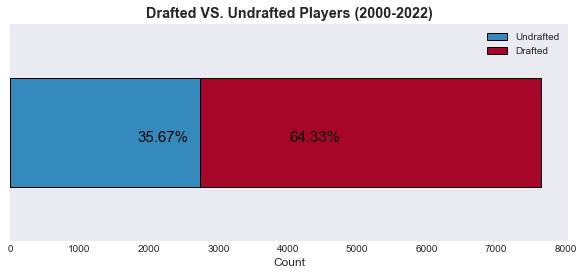

In [27]:
# create dict of drafted/undrafted with sums of each category
total = ['']

data = {'Undrafted': [drafted['Undrafted'].sum()],
        'Drafted': [drafted['Drafted'].sum()]
        }

# new drafted_total df
drafted_total = pd.DataFrame(data,
                       columns=['Undrafted', 'Drafted'],
                       index = total)

plt.style.use('seaborn-dark')

fig, ax = plt.subplots(figsize=(10, 4))

drafted_total.plot(kind = 'barh',
             edgecolor = "black",
             linewidth = 1,
             ax = ax, stacked = True)

# create a list to collect the plt.patches data
totals = []

# find the values and append to list
for i in ax.patches:
    totals.append(i.get_width())

# set individual bar lables using above list
total = sum(totals)

# set individual bar lables using above list
for i in ax.patches:
    # get_width pulls left or right; get_y pushes up or down
    ax.text(i.get_width()-900, i.get_y()+.21, \
            str(round((i.get_width()/total)*100, 2))+'%', 
            fontsize=15,
            color='black')

ax.set_xlabel('Count')

ax.set(ylabel=None)
ax.set_title('Drafted VS. Undrafted Players (2000-2022)', weight = "bold")
ax.legend()

plt.show()

In [28]:
# get a sense of average metrics of drafted vs undrafted players
aggs = df.groupby('Drafted').agg(['mean', 'std'])
aggs

Wt                 40yd             Vertical            \
               mean        std      mean       std       mean       std   
Drafted                                                                   
0        238.130451  44.166829  4.827518  0.304425  32.126826  4.183633   
1        245.289313  45.624052  4.748869  0.301366  33.299948  4.178520   

             Bench            Broad Jump               3Cone            \
              mean       std        mean       std      mean       std   
Drafted                                                                  
0        19.449483  6.088900  113.015686  9.188386  7.338688  0.437711   
1        21.419760  6.421818  115.434121  9.330657  7.256132  0.403689   

          Shuttle              Height            
             mean       std      mean       std  
Drafted                                          
0        4.438029  0.274793  6.126918  0.222148  
1        4.379040  0.260637  6.161254  0.218508

## Below is just a check to see clustering of predictors

In [29]:
# a prelim check to see classification of drafted vs undrafted for each predictor
# sns.pairplot(hue = 'Drafted', data = df, height = 1.75)


## Train-Test Split

Based on the early exploratory data analysis on the drafted vs. undrafted players, this dataset is relatively imbalanced at a 2:1 ratio. Below we will perform a Train-Test Split and specify a `stratify=y` to ensure an even balance of drafted and undrafted player in the split. 

In [30]:
# feature selection, target variable = 'Drafted'
X = df.drop(['Drafted'], axis = 1)
y = df['Drafted']
X_train, X_test, y_train, y_test = train_test_split(X, y, stratify = y, random_state= 42)

In [31]:
# feature selection, target variable = 'Drafted'
X_drop_school = df.drop(['Drafted', 'School'], axis = 1)
y_drop_school = df['Drafted']
X_train_drop_school, X_test_drop_school, y_train_drop_school, y_test_drop_school = train_test_split(X_drop_school, y_drop_school, stratify = y, random_state= 42)

In [32]:
print(X_train.shape)
print(X_test.shape)
print(y_train.shape)
print(y_test.shape)

(5738, 10)
(1913, 10)
(5738,)
(1913,)


In [33]:
# check that percent in y_train and y_test for drafted is balanced
print("Train percent Drafted:", y_train.value_counts(normalize=True)[1])
print("Test percent Drafted: ", y_test.value_counts(normalize=True)[1])

Train percent Drafted: 0.6432554897176717
Test percent Drafted:  0.643491897543126


### Handling Missing Values

In [34]:
X_train.isna().sum()

Pos              0
School           0
Wt               0
40yd           344
Vertical      1330
Bench         1943
Broad Jump    1378
3Cone         2173
Shuttle       2097
Height           0
dtype: int64

In [35]:
f = (X_train['40yd'].isna().sum()/X_train.shape[0]).round(2) * 100
v = (X_train['Vertical'].isna().sum()/X_train.shape[0]).round(2) * 100
b = (X_train['Bench'].isna().sum()/X_train.shape[0]).round(2) * 100
bj = (X_train['Broad Jump'].isna().sum()/X_train.shape[0]).round(2) * 100
c = (X_train['3Cone'].isna().sum()/X_train.shape[0]).round(2) * 100
s = (X_train['Shuttle'].isna().sum()/X_train.shape[0]).round(2) * 100

print(f'{f}% of 40yd is missing.')
print(f'{v}% of Vertical is missing.')
print(f'{b}% of Bench is missing.')
print(f'{bj}% of Broad Jump is missing.')
print(f'{c}% of 3Cone is missing.')
print(f'{s}% of Shuttle is missing.')

6.0% of 40yd is missing.
23.0% of Vertical is missing.
34.0% of Bench is missing.
24.0% of Broad Jump is missing.
38.0% of 3Cone is missing.
37.0% of Shuttle is missing.


A large majority of values are missing in this data set as evidenced from the above. I can fill in the NaNs with the average (mean) grouped by position. It would make sense to group by position since some players may be faster than others simply by the nature of their position and their overall build. 

In [36]:
X_train.head()

,Pos,School,Wt,40yd,Vertical,Bench,Broad Jump,3Cone,Shuttle,Height
6651,S,Kentucky,208.0,4.39,33.5,19.0,113.0,NaN,NaN,5.92
6261,DT,Fort Hays State,315.0,5.09,31.0,NaN,112.0,7.5,4.53,6.42
6174,QB,Nebraska,218.0,4.98,32.0,NaN,115.0,7.0,4.41,6.33
7742,EDGE,Cincinnati,228.0,4.67,33.0,NaN,120.0,NaN,4.37,6.42
7016,DL,Ohio State,264.0,NaN,NaN,NaN,NaN,NaN,NaN,6.42


In [37]:
# for each missing value in the columns, replace with the mean of that position 
X_train['40yd'] = X_train['40yd'].fillna(df.groupby('Pos')['40yd'].transform('mean'))
X_train['Vertical'] = X_train['Vertical'].fillna(df.groupby('Pos')['Vertical'].transform('mean'))
X_train['Bench'] = X_train['Bench'].fillna(df.groupby('Pos')['Bench'].transform('mean'))
X_train['Broad Jump'] = X_train['Broad Jump'].fillna(df.groupby('Pos')['Broad Jump'].transform('mean'))
X_train['3Cone'] = X_train['3Cone'].fillna(df.groupby('Pos')['3Cone'].transform('mean'))
X_train['Shuttle'] = X_train['Shuttle'].fillna(df.groupby('Pos')['Shuttle'].transform('mean'))

In [38]:
# create a helper function for the above for future use
def fill_missing(df):
    """ 
    Helper function that takes in columns from a dataframe and fills in the NaNs 
    with the means grouped by Position. Can be used for the training and test sets. 
    """
    missing_cols = ['40yd', 'Vertical', 'Bench', 'Broad Jump', '3Cone', 'Shuttle']
    
    for col in missing_cols:
        df[col] = df[col].fillna(df.groupby('Pos')[col].transform('mean'))
    
    return df
    

In [39]:
# fill missing in X_train
fill_missing(X_train)

,Pos,School,Wt,40yd,Vertical,Bench,Broad Jump,3Cone,Shuttle,Height
6651,S,Kentucky,208.0,4.390000,33.500000,19.000000,113.000000,7.002910,4.204769,5.92
6261,DT,Fort Hays State,315.0,5.090000,31.000000,27.552561,112.000000,7.500000,4.530000,6.42
6174,QB,Nebraska,218.0,4.980000,32.000000,19.300000,115.000000,7.000000,4.410000,6.33
7742,EDGE,Cincinnati,228.0,4.670000,33.000000,22.902439,120.000000,7.146000,4.370000,6.42
7016,DL,Ohio State,264.0,4.975784,30.680645,25.903226,111.595506,7.576301,4.614865,6.42
...,...,...,...,...,...,...,...,...,...,...
1599,RB,Northern Illinois,237.0,4.490000,31.000000,22.000000,114.000000,7.500000,4.150000,5.83
3257,DE,Wisconsin,266.0,4.860000,30.500000,24.000000,112.000000,7.680000,4.880000,6.42
4638,WR,Baylor,208.0,4.520000,32.500000,11.000000,119.000000,7.010000,4.320000,6.17
3229,TE,Fresno State,251.0,4.890000,26.500000,20.157576,107.000000,7.650000,4.550000,6.42


In [40]:
X_train.isna().sum()

Pos            0
School         0
Wt             0
40yd           0
Vertical       0
Bench          0
Broad Jump     0
3Cone         76
Shuttle       76
Height         0
dtype: int64

After filling in the missing values with the means, we still have missing values for 3Cone and Shuttle drills. 

Upon closer inspection, Kickers do not perform in the 3Cone and Shuttle drills. This makes sense because there really is no need for them to perform these drills for their particular skillsets. 

In [41]:
# confirm that kickers do not perform 3Cone and Shuttle Drills
# isolate for dataframe with just Kickers
kickers = X_train[X_train['Pos'] == 'K']
display(kickers.head())
print("3Cone Mean for Kickers:", kickers['3Cone'].mean(), ", Count of NaN:", kickers['3Cone'].isna().sum())
print("Shuttle Mean for Kickers:", kickers['Shuttle'].mean(), ", Count of NaN:", kickers['Shuttle'].isna().sum())

,Pos,School,Wt,40yd,Vertical,Bench,Broad Jump,3Cone,Shuttle,Height
3021,K,USC,227.0,4.570000,33.5,25.0,113.5,NaN,NaN,6.17
884,K,North Dakota,190.0,4.910984,33.5,15.2,113.5,NaN,NaN,6.25
7431,K,Stanford,204.0,4.910984,33.5,15.2,113.5,NaN,NaN,6.17
6639,K,LSU,184.0,4.910984,33.5,15.2,113.5,NaN,NaN,5.83
6605,K,Oklahoma,213.0,4.910984,33.5,15.2,113.5,NaN,NaN,5.75


3Cone Mean for Kickers: nan , Count of NaN: 76
Shuttle Mean for Kickers: nan , Count of NaN: 76


There are a few options here; do we fill in the NaNs with 0? This would have a minor impact on the averages for 3Cone and Shuttle, and pull the mean closer to 0. Likely filling these values with 0s will not impact the decision whether a team would draft a kicker since they did not participate in these drills. 

Another option is to drop kickers from the original `df` and just analyze all other positions. Using domain knowledge and a brief analysis on the percentage that kickers make up the dataset (as part of the Special Teams category), dropping these values will not likely impact whether a player is drafted or not. Generally speaking, very few kickers are ever drafted and are not a critical position of need in football. However, dropping kickers from the `X_train` will cause data leakage as rows will be removed from the X_train set. 

We can always reanalyze the kickers and special teams category/sub-group and drop 3Cone and Shuttle columns later. To avoid data leakage, we will fill NaNs with 0s. 

In [42]:
# fill NaNs with 0
X_train = X_train.fillna(0)

In [43]:
# check 
X_train.isna().sum()

Pos           0
School        0
Wt            0
40yd          0
Vertical      0
Bench         0
Broad Jump    0
3Cone         0
Shuttle       0
Height        0
dtype: int64

In [44]:
y_train.shape

(5738,)

In [45]:
X_train.shape

(5738, 10)

### Need to apply the above cleaning steps to the X_test when ready. See below

In [46]:
# apply 'fill_missing' helper function on X_test set too
fill_missing(X_test)

,Pos,School,Wt,40yd,Vertical,Bench,Broad Jump,3Cone,Shuttle,Height
1856,OT,North Carolina,291.0,5.30,27.711538,24.156250,102.475728,7.844737,4.763196,6.33
4490,OLB,UNLV,233.0,4.84,35.500000,25.000000,117.000000,6.910000,4.300000,5.92
5743,QB,Virginia Tech,232.0,4.80,26.500000,23.000000,112.000000,7.167262,4.410000,6.25
6981,WR,Miami,170.0,4.45,36.500000,14.446154,125.000000,6.973559,4.220857,5.75
5081,CB,Tulane,182.0,4.50,33.500000,9.000000,115.000000,7.200000,4.260000,5.83
...,...,...,...,...,...,...,...,...,...,...
5528,DE,Florida,239.0,4.80,34.500000,23.875000,128.000000,7.010000,4.000000,6.50
4182,OLB,Boise State,260.0,4.62,31.500000,19.000000,118.000000,7.070000,4.330000,6.25
1353,DT,Iowa,294.0,4.95,29.193182,23.000000,104.547619,7.675811,4.622632,6.42
5079,OT,Iowa,313.0,5.31,32.000000,17.000000,101.000000,7.840000,4.770000,6.50


In [47]:
X_test.isna().sum()

Pos            0
School         0
Wt             0
40yd           0
Vertical      27
Bench          0
Broad Jump    27
3Cone         27
Shuttle       27
Height         0
dtype: int64

In [48]:
# fill NaNs with 0
X_test = X_test.fillna(0)
X_test_drop_school = X_test_drop_school.fillna(0)

In [49]:
X_test.isna().sum()

Pos           0
School        0
Wt            0
40yd          0
Vertical      0
Bench         0
Broad Jump    0
3Cone         0
Shuttle       0
Height        0
dtype: int64

In [50]:
# final describe check
# show all rows
# pd.set_option('display.max_rows', None)
# check breakdown of summary statistics by Pos
X_train.groupby('Pos').describe().T

Pos                    C          CB          DB          DE          DL  \
Wt     count  128.000000  574.000000   42.000000  384.000000   94.000000   
       mean   302.265625  192.721254  195.547619  268.828125  289.489362   
       std      8.578938    8.763262   11.555175   13.366950   23.394120   
       min    263.000000  169.000000  177.000000  234.000000  248.000000   
       25%    299.000000  187.000000  186.000000  260.000000  266.500000   
...                  ...         ...         ...         ...         ...   
Height min      6.000000    5.580000    5.670000    6.000000    6.000000   
       25%      6.250000    5.830000    5.920000    6.250000    6.170000   
       50%      6.250000    5.920000    5.920000    6.330000    6.250000   
       75%      6.330000    6.000000    6.060000    6.420000    6.330000   
       max      6.420000    6.330000    6.330000    6.670000    6.580000   

Pos                   DT        EDGE          FB         ILB           K  ...  \
Wt     count  382.000000   49.000000   92.000000  209.000000   76.000000  ...   
       mean   307.295812  251.775510  244.445652  242.057416  197.671053  ...   
       std     15.375234    8.708868   11.104265    7.465726   18.904947  ...   
       min    268.000000  228.000000  220.000000  226.000000  144.000000  ...   
       25%    298.000000  248.000000  238.750000  237.000000  184.750000  ...   
...                  ...         ...         ...         ...         ...  ...   
Height min      5.920000    6.000000    5.830000    5.830000    5.330000  ...   
       25%      6.170000    6.250000    5.920000    6.000000    5.897500  ...   
       50%      6.250000    6.250000    6.000000    6.080000    6.000000  ...   
       75%      6.330000    6.330000    6.080000    6.170000    6.080000  ...   
       max      6.580000    6.500000    6.330000    6.420000    6.420000  ...   

Pos                   OG          OL         OLB          OT           P  \
Wt     count  299.000000  107.000000  310.000000  395.000000  109.000000   
       mean   314.558528  309.588785  240.367742  315.716456  212.853211   
       std     12.468178   21.872682    9.997423   14.018139   15.662426   
       min    282.000000  194.000000  204.000000  273.000000  187.000000   
       25%    306.000000  306.000000  233.000000  307.000000  201.000000   
...                  ...         ...         ...         ...         ...   
Height min      6.080000    5.500000    5.830000    6.250000    5.670000   
       25%      6.250000    6.250000    6.080000    6.420000    6.080000   
       50%      6.330000    6.330000    6.170000    6.420000    6.170000   
       75%      6.420000    6.420000    6.250000    6.500000    6.250000   
       max      6.580000    6.670000    6.500000    6.830000    6.580000   

Pos                   QB          RB           S          TE          WR  
Wt     count  311.000000  510.000000  424.000000  325.000000  786.000000  
       mean   221.977492  213.215686  207.292453  253.772308  202.104326  
       std     11.144627   14.343408    9.450097   10.187615   14.939856  
       min    192.000000  168.000000  178.000000  225.000000  155.000000  
       25%    215.000000  204.000000  201.000000  248.000000  191.250000  
...                  ...         ...         ...         ...         ...  
Height min      5.750000    5.420000    5.580000    5.920000    5.420000  
       25%      6.170000    5.750000    5.920000    6.250000    5.920000  
       50%      6.250000    5.830000    6.000000    6.330000    6.080000  
       75%      6.330000    6.000000    6.080000    6.420000    6.170000  
       max      6.580000    6.330000    6.420000    6.670000    6.500000  

[64 rows x 22 columns]

## Pipeline

In [51]:
from sklearn.pipeline import Pipeline

# this will allow us to visualize the pipeline (may not be available in learn-env)
from sklearn import set_config
set_config(display= 'diagram')

In [52]:
# reset display to normal
pd.set_option('display.max_rows', 500)
X_train

,Pos,School,Wt,40yd,Vertical,Bench,Broad Jump,3Cone,Shuttle,Height
6651,S,Kentucky,208.0,4.390000,33.500000,19.000000,113.000000,7.002910,4.204769,5.92
6261,DT,Fort Hays State,315.0,5.090000,31.000000,27.552561,112.000000,7.500000,4.530000,6.42
6174,QB,Nebraska,218.0,4.980000,32.000000,19.300000,115.000000,7.000000,4.410000,6.33
7742,EDGE,Cincinnati,228.0,4.670000,33.000000,22.902439,120.000000,7.146000,4.370000,6.42
7016,DL,Ohio State,264.0,4.975784,30.680645,25.903226,111.595506,7.576301,4.614865,6.42
...,...,...,...,...,...,...,...,...,...,...
1599,RB,Northern Illinois,237.0,4.490000,31.000000,22.000000,114.000000,7.500000,4.150000,5.83
3257,DE,Wisconsin,266.0,4.860000,30.500000,24.000000,112.000000,7.680000,4.880000,6.42
4638,WR,Baylor,208.0,4.520000,32.500000,11.000000,119.000000,7.010000,4.320000,6.17
3229,TE,Fresno State,251.0,4.890000,26.500000,20.157576,107.000000,7.650000,4.550000,6.42


In [53]:
# define numeric columns to be standard scaled
num_cols = X_train.select_dtypes(['int', 'float']).columns

In [54]:
# define categorical columns to be OHE
cat_cols = X_train.select_dtypes(['object']).columns

## Define the seperate pipelines

#### Numeric & Nominal Pipelines

In [55]:
# define numeric transformation pipeline that scales the numbers
numeric_pipeline = Pipeline([('numnorm', StandardScaler())]) # apply a standard scaler

# define a nominal transformation pipeline that OHE the cats, and MaxAbsScales the set
nominal_pipeline = Pipeline([('onehotenc', OneHotEncoder(categories="auto", # ohe the cat variables
                                sparse = False, 
                              #  drop = 'first', 
                                handle_unknown = 'ignore')), 
                             ('onehotnorm', MaxAbsScaler())]) # apply a MaxAbsScaler


Unite the numeric and nominal pipelines into the ColumnTransformer.

In [56]:
# transform the selected columns with nominal, and numeric pipelines
ct = ColumnTransformer(transformers = 
    [("nominalpipe", nominal_pipeline, cat_cols), # ohe and MaxAbsScale the Pos and School variables
     ("numpipe", numeric_pipeline, num_cols)])

# Create a pipeline containing the single column transformer
# ct_pipe = Pipeline(steps=[
#     ("col_transformer", ct)
# ])

# # Use the pipeline to fit and transform the data
# transformed_data = ct_pipe.fit_transform(X_train)


Below cell attempts to relabel the transformed data columns

In [57]:
# Extract the category labels from the OHE within the pipeline
# encoder = ct.named_transformers_["nominalpipe"]
# category_labels = OneHotEncoder.get_feature_names()

# # Make a dataframe with the relevant columns
# pd.DataFrame(transformed_data, columns=np.append(category_labels, num_cols))

In [58]:
# inspect the transformed X_Train
pp_X_train = pd.DataFrame(ct.fit_transform(X_train))
pp_X_train 

,0,1,2,3,4,5,6,7,8,9,...,340,341,342,343,344,345,346,347,348,349
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,-0.768205,-1.292828,0.167087,-0.201004,-0.164736,-0.182745,-0.227160,-1.038787
1,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,...,0.0,0.0,1.587333,1.031585,-0.473770,1.282397,-0.279103,0.362026,0.356867,1.233513
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,-0.548061,0.666320,-0.217427,-0.148970,0.063996,-0.185935,0.141379,0.824499
3,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,...,0.0,0.0,-0.327917,-0.363063,0.038916,0.475856,0.635828,-0.025930,0.069550,1.233513
4,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.464600,0.652322,-0.555634,0.996328,-0.325363,0.445646,0.509262,1.233513
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5733,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,-0.129788,-0.960769,-0.473770,0.319332,-0.050370,0.362026,-0.325511,-1.447801
5734,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.508629,0.267849,-0.601942,0.666222,-0.279103,0.559292,0.985373,1.233513
5735,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,-0.768205,-0.861151,-0.089256,-1.588566,0.521462,-0.174975,-0.020237,0.097363
5736,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.178413,0.367467,-1.627313,-0.000228,-0.850934,0.526414,0.392782,1.233513


In [59]:
# check columntransformer
ct

ColumnTransformer(transformers=[('nominalpipe',
                                 Pipeline(steps=[('onehotenc',
                                                  OneHotEncoder(handle_unknown='ignore',
                                                                sparse=False)),
                                                 ('onehotnorm',
                                                  MaxAbsScaler())]),
                                 Index(['Pos', 'School'], dtype='object')),
                                ('numpipe',
                                 Pipeline(steps=[('numnorm',
                                                  StandardScaler())]),
                                 Index(['Wt', '40yd', 'Vertical', 'Bench', 'Broad Jump', '3Cone', 'Shuttle',
       'Height'],
      dtype='object'))])

## 1st Model - Baseline

We will now go through an iterative process to determine which model suits the dataset best when it comes to classification of those who were drafted or not. As a reminder, we want to have a better baseline accuracy score of about 63% (those who were Drafted) if our model was just simply randomly guessing. 

However, the main metric we'll be focussed on here is the **F1-Score** which takes into consideration a balance between the False Positives and False Negatives into account. In other words, we want to have a harmonized balance between precision and recall. 

- False Positives are players who were labeled as 'Drafted' but they were actually 'Undrafted'

- False Negatives are players who were labeled as 'Undrafted' but they were actually 'Drafted. 

In [60]:
# percentage of those drafted and undrafted
y_train.value_counts(normalize = True)

1    0.643255
0    0.356745
Name: Drafted, dtype: float64

In [61]:
# to hide warnings
from sklearn.utils.testing import ignore_warnings
from sklearn.exceptions import ConvergenceWarning

### Logistic Regression Model

In [152]:
# build baseline log reg pipepline 
steps = [('preprocess', ct), 
         ('model', LogisticRegression(random_state = 42))]

base_log_reg_pipeline = Pipeline(steps)

base_log_reg_pipeline.fit(X_train, y_train)

/Users/eric/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:762: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Pipeline(steps=[('preprocess',
                 ColumnTransformer(transformers=[('nominalpipe',
                                                  Pipeline(steps=[('onehotenc',
                                                                   OneHotEncoder(handle_unknown='ignore',
                                                                                 sparse=False)),
                                                                  ('onehotnorm',
                                                                   MaxAbsScaler())]),
                                                  Index(['Pos', 'School'], dtype='object')),
                                                 ('numpipe',
                                                  Pipeline(steps=[('numnorm',
                                                                   StandardScaler())]),
                                                  Index(['Wt', '40yd', 'Vertical', 'Bench', 'Broad Jump', '3Cone', 'Shuttle',
       'Height'],
      dtype='object'))])),
                ('model', LogisticRegression(random_state=42))])


1st Model - Baseline Logistic Regression F1 Score (Training): 0.8104
1st Model - Baseline Logistic Regression F1 Score (Test): 0.7915
------------------------------------------------------------------------------------------
              precision    recall  f1-score   support

           0       0.64      0.38      0.48       682
           1       0.72      0.88      0.79      1231

    accuracy                           0.70      1913
   macro avg       0.68      0.63      0.63      1913
weighted avg       0.69      0.70      0.68      1913



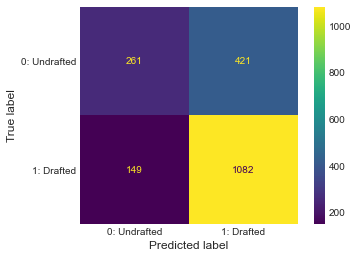

In [153]:
# define class_names for confusion matrix label moving forward
class_names = ['0: Undrafted', '1: Drafted']

# plot baseline log reg matrix on testing set
plot_confusion_matrix(base_log_reg_pipeline, 
                      X_test, y_test, 
                      display_labels = class_names)

print()
print('1st Model - Baseline Logistic Regression F1 Score (Training):', 
      round(f1_score(y_train, base_log_reg_pipeline.predict(X_train)),4))
print('1st Model - Baseline Logistic Regression F1 Score (Test):', 
      round(f1_score(y_test, base_log_reg_pipeline.predict(X_test)),4))
print('-'*90)

# get classification report on the test set
y_pred = base_log_reg_pipeline.predict(X_test)
print(classification_report(y_test, y_pred))

In [154]:
# # code to check feature importances MODIFY
# feat_imp = base_log_reg_pipeline['model'].feature_importances_  
 
# feat_imp_series = pd.Series(feat_imp, 
#           index = X.columns).sort_values(
#     ascending = False)

## Cross Validation Pipeline
### Using `StratifiedKFold`

In [155]:
def cross_validation_pipe(X_train, y_train, estimator, num_split = 10):
    
    score_train_list = []
    score_val_list = []

    # Instantiate a splitter object and loop over its result
    kfold = StratifiedKFold()
    for fold, (train_index, val_index) in enumerate(kfold.split(X_train, y_train)):
        # Extract train and validation subsets using the provided indices
        X_t, X_val = X_train.iloc[train_index], X_train.iloc[val_index]
        y_t, y_val = y_train.iloc[train_index], y_train.iloc[val_index]

        # Clone the provided model and fit it on the train subset
        temp_model = clone(estimator)
        temp_model.fit(X_t, y_t)
        
        # now how did we do?
        f1_train = round(f1_score(y_t, estimator.predict(X_t)),6)
        f1_val = round(f1_score(y_val, estimator.predict(X_val)),6)
        score_val_list.append(f1_val)
        score_train_list.append(f1_train)
        
    return {'Train Score': np.mean(score_train_list), 'Validation Score': np.mean(score_val_list)}

In [156]:
cross_validation_pipe(X_train, y_train, base_log_reg_pipeline)

/Users/eric/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:762: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/Users/eric/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:762: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/mod

{'Train Score': 0.8103874000000001, 'Validation Score': 0.810384}

/Users/eric/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:762: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


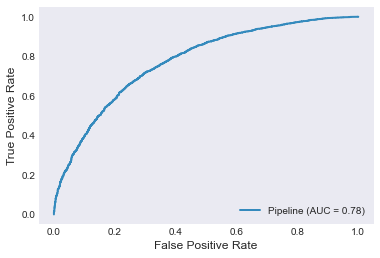

In [157]:
# fit and plot roc curve
base_log_reg_pipeline.fit(X_train, y_train)
plot_roc_curve(base_log_reg_pipeline, X_train, y_train)
plt.show()

## 2nd Model - Tuned Logistic Regression
Lets define a new model and try to improve on the baseline logistic regression model and address the convergence and max iterations warnings. 

In [158]:
# build baseline log reg pipepline 
steps = [('preprocess', ct), 
         ('model', LogisticRegression(random_state = 42))]

base_log_reg_pipeline = Pipeline(steps,verbose = True)

# define new parameters in the grid
logreg_pipe_grid = {'model__penalty': ['l2', 'none'],
             'model__solver': ['lbfgs'],
             'model__C': [0.0001, 0.001, 0.01, 0.1, 1],  
             'model__max_iter': [1e2, 1e3, 1e4, 1e5]}  

# grid search best f1 score
gs_logreg_pipe2 = GridSearchCV(estimator = base_log_reg_pipeline, 
                               param_grid = logreg_pipe_grid,
                               scoring = 'f1')


To save time, below is an example of the grid search in action. Just need to uncomment out the cells. Otherwise, the best parameters have been performed and extracted to fit the 2nd model using the `lbfgs` solver. 

In [159]:
# run this to find best parameters based on gridsearch 
# takes a while!
# gs_logreg_pipe2.fit(X_train, y_train)

In [160]:
# find my best parameters in the log reg model 2, using lbfgs solver
# ---- to save time; below are best results ----- #
# {'model__C': 0.1,
#  'model__max_iter': 100.0,
#  'model__penalty': 'l2',
#  'model__solver': 'lbfgs'}


#gs_logreg_pipe2.best_params_

In [161]:
# whats the best score based on these parameters? using lbfgs solver
# gs_logreg_pipe2.best_score_

In [162]:
# reassign best params to the 2nd model
gs_logreg_pipe2 = gs_logreg_pipe2.best_estimator_
gs_logreg_pipe2

AttributeError: 'GridSearchCV' object has no attribute 'best_estimator_'

In [ ]:
# take best params from above, and redefine in steps for pipeline
model_2_steps = [('preprocess', ct), 
                 ('model', LogisticRegression(random_state = 42, # input best params from grid search
                                              C = 0.1,
                                              max_iter = 100,
                                              penalty = 'l2',
                                              solver = 'lbfgs'))]

gs_logreg_pipe2 = Pipeline(model_2_steps)

gs_logreg_pipe2.fit(X_train, y_train)

# plot confusion matrix 
plot_confusion_matrix(gs_logreg_pipe2, 
                      X_test, y_test,
                      display_labels = class_names)

print('2nd Model - Best Params (lbfgs) Logistic Regression F1 Score (Training):', 
      round(f1_score(y_train, gs_logreg_pipe2.predict(X_train)),4))
print('2nd Model - Best Params (lbfgs) Logistic Regression F1 Score (Test):', 
      round(f1_score(y_test, gs_logreg_pipe2.predict(X_test)),4))
print()
print('Cross Validation Scores:')
display(cross_validation_pipe(X_train, y_train, gs_logreg_pipe2))
print('-'*90)

# get classification report on the test set
y_pred = gs_logreg_pipe2.predict(X_test)
print(classification_report(y_test, y_pred))

# plot roc curve
plot_roc_curve(gs_logreg_pipe2, X_test, y_test)
plt.show()

Still getting alot of False Positives; lets try raising the threshold for the logistic model and see how it performs????

## Adjust threshold in the model? and apply to the confusion matrix?

In [ ]:
# gs_logreg_pipe2.fit(X_train,y_train)
# # y_pred = clf.predict(X_test)  # default threshold is 0.5
# y_pred = (gs_logreg_pipe2.predict_proba(X_test)[:,1] >= 0.6).astype(bool)

In [ ]:
# # Classify with custom threshold (for example, 0.85)
# thr = 0.5
# y_pred = np.where(gs_logreg_pipe2.predict_proba(X_test)[:, 1] >= thr, 1, 0)

# # Score
# print('Accuracy with threshold set to', str(thr) + ':', accuracy_score(y_test, y_pred))

# print('2nd Model Best Parameters (lbfgs solver) Logistic Regression Score:', 
#       round(gs_logreg_pipe2.score(X_train, y_train),3))

In [163]:
# plot_confusion_matrix(gs_logreg_pipe2, X_test, y_test)
# plt.show()

## 3rd Model - Try different Solvers
While we fine tuned the original basesline model, lets now run a grid search on the available logistic regression solvers and determine the optimum solver based on the `C` = 0.1, and `max_iter` = 100.

Run the Grid Search:

In [164]:
# build baseline log reg pipepline 
steps = [('preprocess', ct), 
         ('model', LogisticRegression(random_state = 42))]

base_log_reg_pipeline = Pipeline(steps)

# define new parameters in the grid
solvers_pipe_grid = {'model__solver': ['newton-cg', 'lbfgs', 'liblinear', 'sag', 'saga'],
                     'model__C': [0.1],  
                     'model__max_iter': [1e2]}  

# scoring on F1
best_solver_pipe3 = GridSearchCV(estimator = base_log_reg_pipeline, 
                                 param_grid = solvers_pipe_grid,
                                 scoring = 'f1') 

# run this to find best parameters based on gridsearch 
best_solver_pipe3.fit(X_train, y_train)

GridSearchCV(estimator=Pipeline(steps=[('preprocess',
                                        ColumnTransformer(transformers=[('nominalpipe',
                                                                         Pipeline(steps=[('onehotenc',
                                                                                          OneHotEncoder(handle_unknown='ignore',
                                                                                                        sparse=False)),
                                                                                         ('onehotnorm',
                                                                                          MaxAbsScaler())]),
                                                                         Index(['Pos', 'School'], dtype='object')),
                                                                        ('numpipe',
                                                                         Pipeline(steps=[('numnorm',
                                                                                          StandardScaler())]),
                                                                         Index(['Wt', '40yd', 'Vertical', 'Bench', 'Broad Jump', '3Cone', 'Shuttle',
       'Height'],
      dtype='object'))])),
                                       ('model',
                                        LogisticRegression(random_state=42))]),
             param_grid={'model__C': [0.1], 'model__max_iter': [100.0],
                         'model__solver': ['newton-cg', 'lbfgs', 'liblinear',
                                           'sag', 'saga']},
             scoring='f1')

In [165]:
display(best_solver_pipe3.best_params_)
display(best_solver_pipe3.best_score_)

{'model__C': 0.1, 'model__max_iter': 100.0, 'model__solver': 'liblinear'}

0.7984250172759182

So based on the grid search above, our best solver is the `liblinear`. Lets now apply this model with this solver.
### Using the `liblinear` model

In [166]:
# build baseline log reg pipepline 
steps = [('preprocess', ct), 
         ('model', LogisticRegression(random_state = 42))]

base_log_reg_pipeline = Pipeline(steps)

# define new parameters in the grid
best_solver_pipe_grid = {'model__solver': ['liblinear'],
                     'model__penalty': ['l1', 'l2'],
                     'model__C': [0.01],  
                     'model__max_iter': [1e2]}  

# run this to find best parameters based on gridsearch 
best_solver_pipe3.fit(X_train, y_train)

display(best_solver_pipe3.best_params_)
display(best_solver_pipe3.best_score_)

{'model__C': 0.1, 'model__max_iter': 100.0, 'model__solver': 'liblinear'}

0.7984250172759182

3rd Model -  Liblinear F1 Score: (Training): 0.8067
3rd Model - Liblinear F1 Score (Test): 0.7918

Cross Validation Scores:


{'Train Score': 0.8067078000000001, 'Validation Score': 0.8066988}

------------------------------------------------------------------------------------------
              precision    recall  f1-score   support

           0       0.64      0.37      0.47       682
           1       0.72      0.88      0.79      1231

    accuracy                           0.70      1913
   macro avg       0.68      0.63      0.63      1913
weighted avg       0.69      0.70      0.68      1913



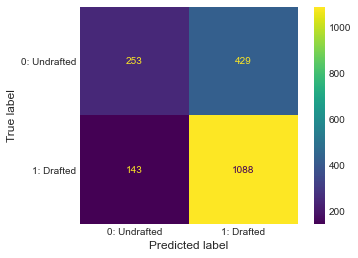

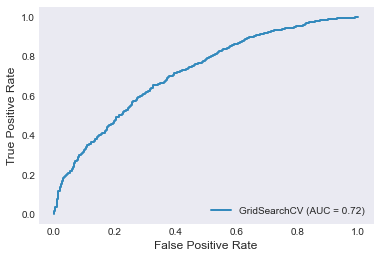

In [167]:
# plot matrix
plot_confusion_matrix(best_solver_pipe3, 
                      X_test, y_test, 
                      display_labels = class_names)

# get scores
print('3rd Model -  Liblinear F1 Score: (Training):', 
      round(f1_score(y_train, best_solver_pipe3.predict(X_train)),4))
print('3rd Model - Liblinear F1 Score (Test):', 
      round(f1_score(y_test, best_solver_pipe3.predict(X_test)),4))
print()
print('Cross Validation Scores:')
display(cross_validation_pipe(X_train, y_train, best_solver_pipe3))
print('-'*90)

# get classification report on the test set
y_pred = best_solver_pipe3.predict(X_test)
print(classification_report(y_test, y_pred))

# plot roc curve
plot_roc_curve(best_solver_pipe3, X_test, y_test)
plt.show()

**Conclusions:**
- After running a few logistic regression models, we arent really performing better than the baseline model. While we addressed the `max_iter` and `Convergence` issues, the baseline logistic regression model performed the best on the test set thus far. 

Lets now move on and try different classifier types. 

## 4th Model - Decision Tree Classifier (DCT)
Note: While we do not need to scale or OHE the X_train for a Decision Tree Classifier, we'll just leave it in the pipeline for the sake of ease. 

In [168]:
# build new DCT pipeline 
steps = [('preprocess', ct), 
         ('dt_clf', DecisionTreeClassifier (random_state = 42))]

dt_clf_pipe4 = Pipeline(steps)

dt_clf_pipe4.fit(X_train,y_train)

Pipeline(steps=[('preprocess',
                 ColumnTransformer(transformers=[('nominalpipe',
                                                  Pipeline(steps=[('onehotenc',
                                                                   OneHotEncoder(handle_unknown='ignore',
                                                                                 sparse=False)),
                                                                  ('onehotnorm',
                                                                   MaxAbsScaler())]),
                                                  Index(['Pos', 'School'], dtype='object')),
                                                 ('numpipe',
                                                  Pipeline(steps=[('numnorm',
                                                                   StandardScaler())]),
                                                  Index(['Wt', '40yd', 'Vertical', 'Bench', 'Broad Jump', '3Cone', 'Shuttle',
       'Height'],
      dtype='object'))])),
                ('dt_clf', DecisionTreeClassifier(random_state=42))])

In [169]:
# run cross validation - will print a perfect value since this is a DT classifier (overfits!)
cross_validation_pipe(X_train, y_train, dt_clf_pipe4)

{'Train Score': 1.0, 'Validation Score': 1.0}

We know that decision tree classifiers naturally overfits and perfectly classifies the training set and thus explains the perfect training and validation scores. 

However, lets check the test set with the DTC. 

4th Model - Decision Tree F1 Score (Training): 1.0
4th Model - Decision Tree F1 Score (Test): 0.717

Cross Validation Scores:


{'Train Score': 1.0, 'Validation Score': 1.0}

------------------------------------------------------------------------------------------
              precision    recall  f1-score   support

           0       0.48      0.44      0.46       682
           1       0.70      0.73      0.72      1231

    accuracy                           0.63      1913
   macro avg       0.59      0.59      0.59      1913
weighted avg       0.62      0.63      0.62      1913



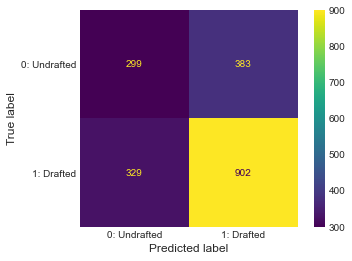

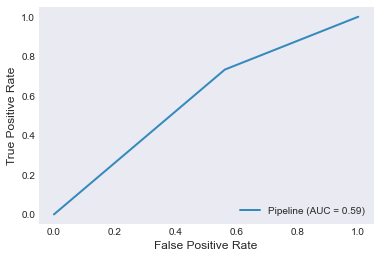

In [171]:
# plot matrix
plot_confusion_matrix(dt_clf_pipe4, 
                      X_test, y_test, 
                      display_labels = class_names)

# get scores
print('4th Model - Decision Tree F1 Score (Training):', 
      round(f1_score(y_train, dt_clf_pipe4.predict(X_train)),4))
print('4th Model - Decision Tree F1 Score (Test):', 
      round(f1_score(y_test, dt_clf_pipe4.predict(X_test)),4))
print()
print('Cross Validation Scores:')
display(cross_validation_pipe(X_train, y_train, dt_clf_pipe4))
print('-'*90)

# get classification report on the test set
y_pred = dt_clf_pipe4.predict(X_test)
print(classification_report(y_test, y_pred))

# plot roc curve
plot_roc_curve(dt_clf_pipe4, X_test, y_test)
plt.show()

## 4B Model - Pruning the Decision Tree Classifier (DCT)

Clearly the DCT needs to be worked with. Lets now run a grid search on the optimum hyperparameters for the DCT. 

In [172]:
# build baseline log reg pipepline 
steps = [('preprocess', ct), 
         ('dt_clf', DecisionTreeClassifier(random_state = 42))]

dt_clf_pipe4b = Pipeline(steps)

dt_clf_pipe4b.fit(X_train, y_train)

# define new parameters in the grid
dt_pipe_grid = {'dt_clf__criterion': ['gini', 'entropy'],
                'dt_clf__max_depth': [1, 10, 20],  
                'dt_clf__min_samples_split': [ 2, 3, 5, 10],
                'dt_clf__min_samples_leaf': [ 2, 3, 5, 10]}  
#                 'dt_clf__min_samples_split': [0.01, 0.1, 0.5, 1.0],
#                 'dt_clf__min_samples_leaf': [0.01, 0.1, 0.25, 0.5]}  

# grid search with default accuracy scoring, because error with f1 scoring
dt_clf_pipe4b = GridSearchCV(estimator = dt_clf_pipe4b, 
                             param_grid = dt_pipe_grid) 

# run this to find best parameters based on gridsearch 
dt_clf_pipe4b.fit(X_train, y_train)

# get best scores and parameters
display(dt_clf_pipe4b.best_params_)
display(dt_clf_pipe4b.best_score_)

{'dt_clf__criterion': 'entropy',
 'dt_clf__max_depth': 10,
 'dt_clf__min_samples_leaf': 10,
 'dt_clf__min_samples_split': 2}

0.6709612107330439

4B Model - Decision Tree F1 Score (Training): 0.8302
4B Model - Decision Tree F1 Score (Test): 0.7542

Cross Validation Scores:


{'Train Score': 0.8302514000000001, 'Validation Score': 0.830316}

------------------------------------------------------------------------------------------
              precision    recall  f1-score   support

           0       0.53      0.40      0.46       682
           1       0.71      0.81      0.75      1231

    accuracy                           0.66      1913
   macro avg       0.62      0.60      0.60      1913
weighted avg       0.65      0.66      0.65      1913



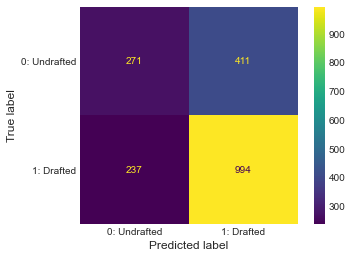

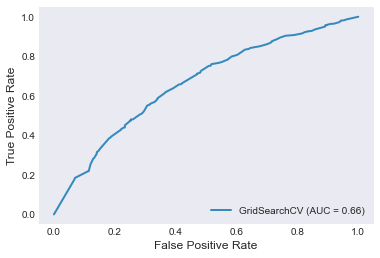

In [173]:
# plot matrix
plot_confusion_matrix(dt_clf_pipe4b, 
                      X_test, y_test, 
                      display_labels = class_names)

# get scores
print('4B Model - Decision Tree F1 Score (Training):', 
      round(f1_score(y_train, dt_clf_pipe4b.predict(X_train)),4))
print('4B Model - Decision Tree F1 Score (Test):', 
      round(f1_score(y_test, dt_clf_pipe4b.predict(X_test)),4))
print()
print('Cross Validation Scores:')
display(cross_validation_pipe(X_train, y_train, dt_clf_pipe4b))
print('-'*90)

# get classification report on the test set
y_pred = dt_clf_pipe4b.predict(X_test)
print(classification_report(y_test, y_pred))

# plot roc curve
plot_roc_curve(dt_clf_pipe4b, X_test, y_test)
plt.show()

## KNN Classifier

In [196]:
# build baseline log reg pipepline 
steps = [('preprocess', ct), 
         ('knn', KNeighborsClassifier())]

knn_pipe = Pipeline(steps)

knn_pipe.fit(X_train, y_train)

# define new parameters in the grid
knn_pipe_grid = {'knn__n_neighbors': [5, 11, 15, 21],
                 'knn__p': [1, 2, 3, 4]} 

# grid search with f1 scoring
knn_pipe = GridSearchCV(estimator = knn_pipe, 
                        param_grid = knn_pipe_grid,
                        scoring = 'f1') 

# run this to find best parameters based on gridsearch 
knn_pipe.fit(X_train, y_train)

# get best scores and parameters
display(knn_pipe.best_params_)
display(knn_pipe.best_score_)

{'knn__n_neighbors': 21, 'knn__p': 2}

0.7902452248824419

5th Model - KNN F1 Score (Training): 0.8073
5th Model - KNN F1 Score (Test): 0.7852

------------------------------------------------------------------------------------------
              precision    recall  f1-score   support

           0       0.62      0.27      0.38       682
           1       0.69      0.91      0.79      1231

    accuracy                           0.68      1913
   macro avg       0.66      0.59      0.58      1913
weighted avg       0.67      0.68      0.64      1913



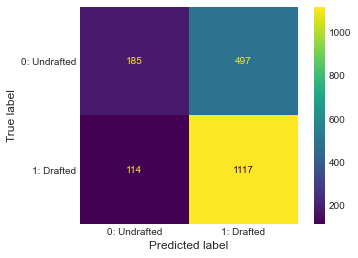

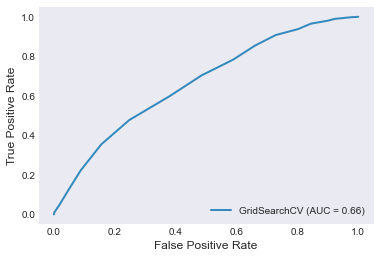

In [198]:
# plot matrix
plot_confusion_matrix(knn_pipe, 
                      X_test, y_test, 
                      display_labels = class_names)

# get scores
print('5th Model - KNN F1 Score (Training):', 
      round(f1_score(y_train, knn_pipe.predict(X_train)),4))
print('5th Model - KNN F1 Score (Test):', 
      round(f1_score(y_test, knn_pipe.predict(X_test)),4))
print()
# print('Cross Validation Scores:')
# display(cross_validation_pipe(X_train, y_train, knn_pipe))
print('-'*90)

# get classification report on the test set
y_pred = knn_pipe.predict(X_test)
print(classification_report(y_test, y_pred))

# plot roc curve
plot_roc_curve(knn_pipe, X_test, y_test)
plt.show()

## ADABoost & Gradient Boosting

In [174]:
from sklearn.ensemble import AdaBoostClassifier, GradientBoostingClassifier

In [175]:
# Instantiate an AdaBoostClassifier
steps1 = [('preprocess', ct), 
         ('abc_clf', AdaBoostClassifier(random_state = 42))]

steps2 = [('preprocess', ct), 
         ('gbt_clf', GradientBoostingClassifier(random_state = 42))]

abc_clf = Pipeline(steps1)
gbt_clf = Pipeline(steps2)

abc_clf.fit(X_train, y_train)
gbt_clf.fit(X_train, y_train)

# AdaBoost model predictions
adaboost_train_preds = abc_clf.predict(X_train)
adaboost_test_preds = abc_clf.predict(X_test)

# GradientBoosting model predictions
gbt_clf_train_preds = gbt_clf.predict(X_train)
gbt_clf_test_preds = gbt_clf.predict(X_test)

In [176]:
def display_acc_and_f1_score(true, preds, model_name):
    acc = accuracy_score(true, preds)
    f1 = f1_score(true, preds)
    print("Model: {}".format(model_name))
    print("Accuracy: {}".format(acc))
    print("F1-Score: {}".format(f1))
    
print("Training Metrics")
display_acc_and_f1_score(y_train, adaboost_train_preds, model_name='AdaBoost')
print("")
display_acc_and_f1_score(y_train, gbt_clf_train_preds, model_name='Gradient Boosted Trees')
print("")
print("Testing Metrics")
display_acc_and_f1_score(y_test, adaboost_test_preds, model_name='AdaBoost')
print("")
display_acc_and_f1_score(y_test, gbt_clf_test_preds, model_name='Gradient Boosted Trees')

Training Metrics
Model: AdaBoost
Accuracy: 0.7312652492157546
F1-Score: 0.8067184758084733

Model: Gradient Boosted Trees
Accuracy: 0.7537469501568491
F1-Score: 0.8272827282728272

Testing Metrics
Model: AdaBoost
Accuracy: 0.7004704652378463
F1-Score: 0.7914088096104841

Model: Gradient Boosted Trees
Accuracy: 0.705697856769472
F1-Score: 0.7984246330110991


### Adaboost Performance

Xth Model - Adaboost F1 Score (Training): 0.8067
Xth Model - Adaboost F1 Score (Test): 0.7914

Cross Validation Scores:


{'Train Score': 0.8067182, 'Validation Score': 0.8067146000000001}

------------------------------------------------------------------------------------------
              precision    recall  f1-score   support

           0       0.64      0.37      0.47       682
           1       0.72      0.88      0.79      1231

    accuracy                           0.70      1913
   macro avg       0.68      0.63      0.63      1913
weighted avg       0.69      0.70      0.68      1913



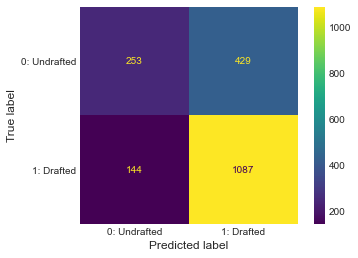

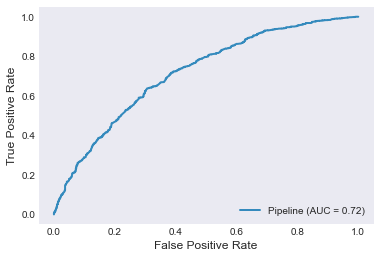

In [177]:
# plot matrix
plot_confusion_matrix(abc_clf, 
                      X_test, y_test, 
                      display_labels = class_names)

# get scores
print('Xth Model - Adaboost F1 Score (Training):', 
      round(f1_score(y_train, abc_clf.predict(X_train)),4))
print('Xth Model - Adaboost F1 Score (Test):', 
      round(f1_score(y_test, abc_clf.predict(X_test)),4))
print()
print('Cross Validation Scores:')
display(cross_validation_pipe(X_train, y_train, abc_clf))
print('-'*90)

# get classification report on the test set
y_pred = abc_clf.predict(X_test)
print(classification_report(y_test, y_pred))

# plot roc curve
plot_roc_curve(abc_clf, X_test, y_test)
plt.show()

### Gradient Boost Performance

Xth Model - Gradient Boost Score (Training): 0.8273
Xth Model - Gradient Boost Score (Test): 0.7984

              precision    recall  f1-score   support

           0       0.67      0.34      0.45       682
           1       0.71      0.91      0.80      1231

    accuracy                           0.71      1913
   macro avg       0.69      0.63      0.63      1913
weighted avg       0.70      0.71      0.68      1913



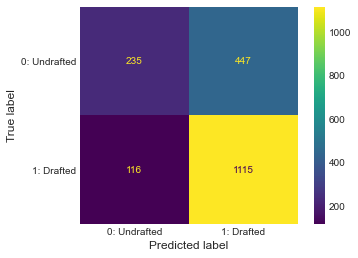

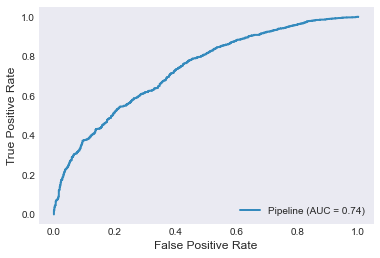

In [178]:
# plot matrix
plot_confusion_matrix(gbt_clf, 
                      X_test, y_test, 
                      display_labels = class_names)

# get scores
print('Xth Model - Gradient Boost Score (Training):', 
      round(f1_score(y_train, gbt_clf.predict(X_train)),4))
print('Xth Model - Gradient Boost Score (Test):', 
      round(f1_score(y_test, gbt_clf.predict(X_test)),4))
print()

# get classification report on the test set
y_pred = gbt_clf.predict(X_test)
print(classification_report(y_test, y_pred))

# plot roc curve
plot_roc_curve(gbt_clf, X_test, y_test)
plt.show()

## XGBoost Model

In [179]:
from xgboost import XGBClassifier

In [180]:
# Instantiate an XGB Classifier
steps = [('preprocess', ct), 
         ('xgb_clf', XGBClassifier(random_state = 42))]

xgb_clf = Pipeline(steps)

xgb_clf.fit(X_train, y_train)

# Predict on training and test sets
training_preds = xgb_clf.predict(X_train)
test_preds = xgb_clf.predict(X_test)

# Accuracy of training and test sets
training_accuracy = accuracy_score(y_train, training_preds)
test_accuracy = accuracy_score(y_test, test_preds)

print('Training Accuracy: {:.4}%'.format(training_accuracy * 100))
print('Validation accuracy: {:.4}%'.format(test_accuracy * 100))

Training Accuracy: 88.85%
Validation accuracy: 69.79%


In [181]:
# Instantiate an XGB Classifier
steps = [('preprocess', ct), 
         ('xgb_clf', XGBClassifier(random_state = 42))]

xgb_clf = Pipeline(steps)

xgb_clf.fit(X_train, y_train)

param_grid = {
    'xgb_clf__learning_rate': [0.1],
    'xgb_clf__max_depth': [5],
    'xgb_clf__min_child_weight': [4],
    'xgb_clf__n_estimators': [60],
    'xgb_clf__subsample': [0.8]
} 

# note: default scoring is aaccuracy
xgb_clf = GridSearchCV(estimator = xgb_clf, 
                       param_grid = param_grid) # goes through all parameters in the defined grid

# run this to find best parameters based on gridsearch 
xgb_clf.fit(X_train, y_train)

# get best scores and parameters
display(xgb_clf.best_params_)
display(xgb_clf.best_score_)

{'xgb_clf__learning_rate': 0.1,
 'xgb_clf__max_depth': 5,
 'xgb_clf__min_child_weight': 4,
 'xgb_clf__n_estimators': 60,
 'xgb_clf__subsample': 0.8}

0.7204614978021745

In [182]:
# Instantiate an XGB Classifier
steps = [('preprocess', ct), 
         ('xgb_clf', XGBClassifier(random_state = 42))]

xgb_clf = Pipeline(steps)

xgb_clf.fit(X_train, y_train)

param_grid = {
    'xgb_clf__learning_rate': [0.1],
    'xgb_clf__max_depth': [5],
    'xgb_clf__min_child_weight': [4],
    'xgb_clf__n_estimators': [60],
    'xgb_clf__subsample': [0.8]
} 

# note: default scoring is aaccuracy
xgb_clf = GridSearchCV(estimator = xgb_clf, 
                       param_grid = param_grid) # goes through all parameters in the defined grid

# run this to find best parameters based on gridsearch 
xgb_clf.fit(X_train, y_train)

best_parameters = xgb_clf.best_params_

print('Grid Search found the following optimal parameters: ')
for param_name in sorted(best_parameters.keys()):
    print('%s: %r' % (param_name, best_parameters[param_name]))

training_preds = xgb_clf.predict(X_train)
test_preds = xgb_clf.predict(X_test)
training_accuracy = accuracy_score(y_train, training_preds)
test_accuracy = accuracy_score(y_test, test_preds)

print('')
print('Training Accuracy: {:.4}%'.format(training_accuracy * 100))
print('Test Accuracy: {:.4}%'.format(test_accuracy * 100))

Grid Search found the following optimal parameters: 
xgb_clf__learning_rate: 0.1
xgb_clf__max_depth: 5
xgb_clf__min_child_weight: 4
xgb_clf__n_estimators: 60
xgb_clf__subsample: 0.8

Training Accuracy: 76.8%
Test Accuracy: 70.31%


Xth Model - XGBoost Score (Training): 0.768
Xth Model - XGBoost Score (Test): 0.703

              precision    recall  f1-score   support

           0       0.65      0.37      0.47       682
           1       0.72      0.89      0.79      1231

    accuracy                           0.70      1913
   macro avg       0.68      0.63      0.63      1913
weighted avg       0.69      0.70      0.68      1913



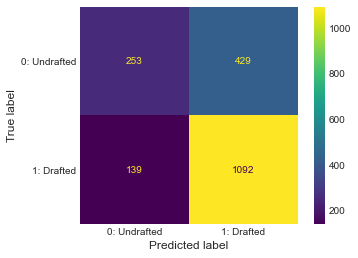

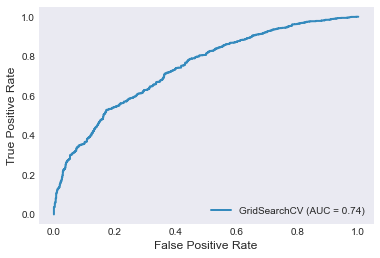

In [183]:
# plot matrix
plot_confusion_matrix(xgb_clf, 
                      X_test, y_test, 
                      display_labels = class_names)

# get scores
print('Xth Model - XGBoost Score (Training):', 
      round(xgb_clf.score(X_train, y_train),3))
print('Xth Model - XGBoost Score (Test):', 
      round(xgb_clf.score(X_test, y_test),3))
print()

# get classification report on the test set
y_pred = xgb_clf.predict(X_test)
print(classification_report(y_test, y_pred))

# plot roc curve
plot_roc_curve(xgb_clf, X_test, y_test)
plt.show()

In [184]:
offense_X = offense.drop(columns = 'Drafted')
offense_y = offense['Drafted']

In [185]:
off_X_train, off_X_test, off_y_train, off_y_test = train_test_split(offense_X, offense_y, test_size=0.33, random_state=42)

In [ ]:
fill_missing(off_X_train)
fill_missing(off_X_test)

In [ ]:



steps = [('preprocess', ct), 
         ('model', LogisticRegression(random_state = 42))]

lr_pipe_off = Pipeline(steps)

# define new parameters in the grid
pipe_grid = {'model__solver': ['liblinear'],
                     'model__penalty': ['l1', 'l2'],
                     'model__C': [0.1],  
                     'model__max_iter': [1e2]}  

# note: default scoring is aaccuracy
lr_pipe_off = GridSearchCV(estimator = lr_pipe_off, # runs through the original pipeline
                       param_grid = pipe_grid) # goes through all parameters in the defined grid

# run this to find best parameters based on gridsearch 

lr_pipe_off.fit(off_X_train, off_y_train)

In [ ]:
# plot matrix
plot_confusion_matrix(lr_pipe_off, 
                      off_X_test, off_y_test, 
                      display_labels = class_names)

# get scores
print('Offense Model - Liblinear Score (Training):', 
      round(lr_pipe_off.score(off_X_train, off_y_train),3))
print('Offense Model - Liblinear Score (Test):', 
      round(lr_pipe_off.score(off_X_test, off_y_test),3))
print()
print('Cross Validation Scores:')
display(cross_validation_pipe(off_X_train, off_y_train, lr_pipe_off))
print('-'*90)

# get classification report on the test set
y_pred = lr_pipe_off.predict(off_X_test)
print(classification_report(off_y_test, y_pred))

# plot roc curve
plot_roc_curve(lr_pipe_off, off_X_test, off_y_test)
plt.show()

In [ ]:
# Instantiate an XGB Classifier
steps = [('preprocess', ct), 
         ('xgb_clf', XGBClassifier(random_state = 42))]

off_xgb_clf = Pipeline(steps)

off_xgb_clf.fit(off_X_train, off_y_train)

param_grid = {
    'xgb_clf__learning_rate': [0.1],
    'xgb_clf__max_depth': [5],
    'xgb_clf__min_child_weight': [4],
    'xgb_clf__n_estimators': [60],
    'xgb_clf__subsample': [0.8]
} 

# note: default scoring is accuracy
off_xgb_clf = GridSearchCV(estimator = off_xgb_clf, 
                       param_grid = param_grid) # goes through all parameters in the defined grid

# run this to find best parameters based on gridsearch 
off_xgb_clf.fit(off_X_train, off_y_train)

# get best scores and parameters
display(off_xgb_clf.best_params_)
display(off_xgb_clf.best_score_)

In [ ]:
# plot matrix
plot_confusion_matrix(off_xgb_clf, 
                      off_X_test, off_y_test, 
                      display_labels = class_names)

# get scores
print('Xth Model - XGBoost Score (Training):', 
      round(off_xgb_clf.score(off_X_train, off_y_train),3))
print('Xth Model - XGBoost Score (Test):', 
      round(off_xgb_clf.score(off_X_test, off_y_test),3))
print()

# get classification report on the test set
y_pred = off_xgb_clf.predict(off_X_test)
print(classification_report(off_y_test, y_pred))

# plot roc curve
plot_roc_curve(off_xgb_clf, off_X_test, off_y_test)
plt.show()